<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio


# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
base_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the random tests
random_search_path = os.path.join(documents_path, "network_random")

<font size=7> Manual Tuning


In [2]:
[board,profile_path,number_of_chips]=obtain_board()

In [1]:
import random
import sqlite3
import os

# Initialize SQLite database
conn = sqlite3.connect('simulation_data.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS simulations (
    iteration INTEGER PRIMARY KEY,
    SST_W0 TEXT,
    SST_W1 TEXT,
    SST_AMPA_GAIN TEXT,
    SST_AMPA_TAU TEXT,
    SST_LEAK TEXT,
    Input_SST REAL,
    PC_SST REAL,
    slope REAL
)
''')
conn.commit()

neuron_config = neuron_configs_bio.config()

neuron_config['PC_Adaptation'] = True
neuron_config['duration'] = 10
neuron_config['input_type'] = 'Regular'
neuron_config['in_freq'] = 20


def randomize_config(neuron_config):
    neuron_config['SST_W0'] = [random.randint(1, 3), random.randint(10, 250)]
    neuron_config['SST_W1'] = [random.randint(1, 3), random.randint(10, 250)]
    neuron_config['SST_AMPA_GAIN'] = [random.randint(1, 3), random.randint(10, 250)]
    neuron_config['SST_AMPA_TAU'] = [random.randint(0, 1), random.randint(10, 250)]
    neuron_config['SST_LEAK']= [0, random.randint(20, 250)]
    neuron_config['Input_SST'] = random.uniform(.05, .5)
    neuron_config['PC_SST'] = random.uniform(.05, .5)

    return neuron_config


@timeout_decorator.timeout(40)  # Set a 5-second timeout

def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )


# Query to get the count of successful simulations
cursor.execute('SELECT COUNT(*) FROM simulations')
successful_simulations = cursor.fetchone()[0]

for i in range(1000):
    neuron_config = randomize_config(neuron_config)
    
    # Check if this configuration has already been tried
    cursor.execute('SELECT * FROM simulations WHERE SST_W0=? AND SST_W1=? AND SST_AMPA_GAIN=? AND SST_AMPA_TAU=? AND SST_LEAK=? AND Input_SST=? AND PC_SST=?',
                  (str(neuron_config['SST_W0']), str(neuron_config['SST_W1']), str(neuron_config['SST_AMPA_GAIN']), str(neuron_config['SST_AMPA_TAU']), str(neuron_config['SST_LEAK']), neuron_config['Input_SST'], neuron_config['PC_SST']))
    if cursor.fetchone():
        print("Configuration already tried, skipping...")
        continue
    
    try:
        
        [output_events, test_config] = run_simulation(neuron_config)
        [cv_values, synchrony_values] = run_dynamic_anal(output_events, test_config)
        fot_output= frequency_over_time(test_config, output_events)
        fvt_fig = frequency_vs_time_plot(frequency_over_time(test_config, output_events), test_config, save=True, annotate=True,neuron_config=neuron_config)
        [time_axis, ff_windows_pc, ff_windows_pv, ff_windows_sst] = fot_output
        slope = calculate_slope(time_axis, ff_windows_sst[:-1])
        print(f"Simulation {successful_simulations + 1} completed successfully!")
        successful_simulations += 1
        
        if successful_simulations >= 2000: # Stop after 100 successful simulations
            break
        # Saving the fvt_figure
        fvt_figure_path = os.path.join(random_search_path, f'fvt_figure_{successful_simulations}.png')
        fvt_fig.savefig(fvt_figure_path)
        
        # Insert data into SQLite database
        cursor.execute('INSERT INTO simulations (iteration, SST_W0, SST_W1, SST_AMPA_GAIN, SST_AMPA_TAU, SST_LEAK, Input_SST, PC_SST, slope, fvt_figure_path) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)',
                      (successful_simulations, str(neuron_config['SST_W0']), str(neuron_config['SST_W1']), str(neuron_config['SST_AMPA_GAIN']), str(neuron_config['SST_AMPA_TAU']), str(neuron_config['SST_LEAK']), neuron_config['Input_SST'], neuron_config['PC_SST'], slope, fvt_figure_path))
        conn.commit()
        
        successful_simulations += 1
        print(f"Simulation {successful_simulations} completed successfully!")
        
        if successful_simulations >= 2000:
            break
    except timeout_decorator.TimeoutError:
        print("Simulation timed out, trying again with new parameters...")
        
print("Completed all successful simulations.")
conn.close()



NameError: name 'neuron_configs_bio' is not defined

NameError: name 'results' is not defined

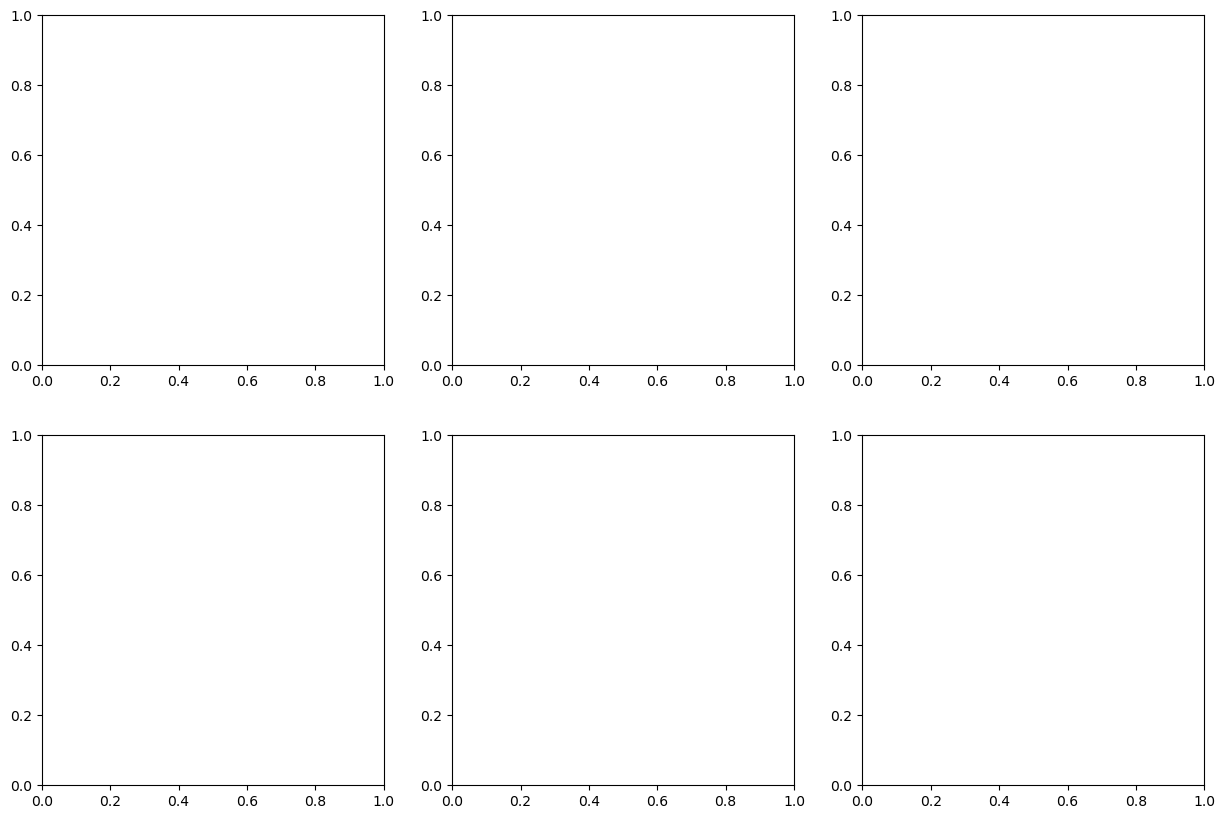

In [ ]:
import matplotlib.pyplot as plt

# Parameters for which you want to create subplots
parameters = ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak', 'input_sst', 'pc_sst']

# Define the number of subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Define marker shapes
markers = ['o', 's', 'v', '^', '<', '>']

# Iterate through each parameter and create subplots
for i, param in enumerate(parameters):
    # If the parameter is not from the first four, there's no coarse value
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        unique_coarse_values = set([r[0][param][0] for r in results if param in r[0]])

        for j, coarse_value in enumerate(unique_coarse_values):
            # Filter the results for the current coarse value
            filtered_results = [(r[0][param][1], r[1]) for r in results if param in r[0] and r[0][param][0] == coarse_value]

            # Separate the fine values and the slopes
            fine_values, slopes = zip(*filtered_results)

            # Plot the data using different marker shapes for each coarse value
            axes[i].scatter(fine_values, slopes, label=f'Coarse value: {coarse_value}', marker=markers[j % len(markers)])
    else:
        # If the parameter is 'input_sst' or 'pc_sst', plot them directly
        values, slopes = zip(*[(r[0][param], r[1]) for r in results if param in r[0]])

        # Plot the data
        axes[i].scatter(values, slopes)

    axes[i].set_title(f'{param.upper()}')
    axes[i].set_xlabel(f'{param} value')
    axes[i].set_ylabel('Firing Rate Increase')

    # Add a legend to distinguish between different coarse values
    if param in ['sst_w0', 'sst_ampa_gain', 'sst_ampa_tau', 'sst_leak']:
        axes[i].legend()

plt.tight_layout()
plt.show()
